# FIT and ruck speed

We want to look at the influence of tackling on ruck speed.

As always, the data is organised with one folder per competition. We specify which competition and which season we want to process.
If we want to process all games, we set both variables to '*'.

In [2]:
comp = "SuperRugbyPacific"
season = "2024-25"

We generate the list of the games we want to process.

In [4]:
import glob

def check_duplicates(my_list):
    seen = set()
    for x in my_list:
        if x in seen:
            print(f"Game {x} has been seen before")
        seen.add(x)

list_games = glob.glob(f"../opta_data/Mens/{comp}/{season}/**/*.csv",recursive=True)

print(f"{len(list_games)} games to process.")
check_duplicates(list_games)

54 games to process.


## Processing one game

We create a function that extracts all the relevant information for us.

The strategy for that function is to identify rucks, extract information from these rucks, then identify the tackles leading to those rucks and extract information from these tackles as well.

In [6]:
def process_game(f):

    game_data = []

    with open(f,'r') as inFile:
        lines = inFile.readlines()

    # Read the header line
    header = lines[0].strip().split(',')
    
    # Determine the index for all the columns we want to use
    homeTeamName = header.index('homeTeamName')
    awayTeamName = header.index('awayTeamName')
    competitionName = header.index('competitionName')
    competitionSeason = header.index('season')
    FXID = header.index('FXID')
    action = header.index('action')
    actionName = header.index('actionName')
    ActionType = header.index('ActionType')
    ActionTypeName = header.index('ActionTypeName')
    Actionresult = header.index('Actionresult')
    ActionResultName = header.index('ActionResultName')
    qualifier3Name = header.index('qualifier3Name')
    qualifier4Name = header.index('qualifier4Name')
    qualifier5Name = header.index('qualifier5Name')
    qualifier6Name = header.index('qualifier6Name')
    ps_timestamp = header.index('ps_timestamp')
    ps_endstamp = header.index('ps_endstamp')
    MatchTime = header.index('MatchTime')
    period = header.index('period')
    x_coord = header.index('x_coord')
    y_coord = header.index('y_coord')
    x_coord_end = header.index('x_coord_end')
    y_coord_end = header.index('y_coord_end')
    teamName = header.index('teamName')
    playerName = header.index('playerName')
    assoc_playerName = header.index('assoc_playerName')
  
    # we start by extracting the values that are constant for the whole game...
    temp_array = lines[1].split(",")
    
    # home and away teams
    home_team = temp_array[homeTeamName]
    away_team = temp_array[awayTeamName]
    
    # competition name and season
    competition_name = temp_array[competitionName]
    competition_season = temp_array[competitionSeason]

    # game ID
    game_ID = temp_array[FXID]
    
    # then we can process each line in the file
    i=1
    while i<len(lines):
        
        temp_array = lines[i].split(",")
        i+=1
        
        action_ID = temp_array[action]

        # if the action is not a ruck, we move on
        if action_ID!="23":
            continue

        # we extract the attacking and defending team
        attacking_team = temp_array[teamName]
        defending_team = home_team
        if attacking_team == home_team:
            defending_team = away_team

        # we extract information about the ruck position
        ruck_position_x = temp_array[x_coord]
        ruck_position_y = temp_array[y_coord]

        ruck_period = temp_array[period]
        ruck_time = temp_array[MatchTime].zfill(5)

        # we extract information about the current time
        time = f"{ruck_period}_{ruck_time}" # time is captured as x_mmmss

        # we extract the ruck duration
        ruck_start = literal_eval(temp_array[ps_timestamp])
        ruck_end = literal_eval(temp_array[ps_endstamp])
        ruck_duration = round(ruck_end-ruck_start,2)

        # we extract the ruck outcome
        ruck_outcome = temp_array[ActionResultName]

        # now we go look for tackles
        j=i-1
        tackles_found = False
        tacklers = {}
        stop_condition = 12

        while j>=0 and j>=(i-stop_condition):
            prev_array = lines[j].split(",")
            action_ID = prev_array[action]
            action_result = prev_array[Actionresult]
            team = prev_array[teamName]
            action_period = prev_array[period]

            # we have found the previous ruck or a restart
            if j<i-1 and (action_ID=="23" or action_ID=="14"):
                j-=(stop_condition+10)
                # tackles_found=False

            # we have found a tackle
            if action_ID=="2":

                # if the team or the period is different, we went to far up, we stop
                if team!=defending_team or action_period!=ruck_period:
                    j-=(stop_condition+10)
                    continue
                    
                tackle_qualifier = prev_array[qualifier5Name]

                # we only consider tackles that are not 'missed':
                if action_result!="161":
                    tackles_found=True
                    tackle_start_time = literal_eval(prev_array[ps_timestamp])
    
                    if tackle_qualifier in tacklers:
                        tacklers[tackle_qualifier] += f", {prev_array[playerName]}"
                    else:
                        tacklers[tackle_qualifier] = prev_array[playerName]
    
                # if it is the 1st tackler, we do not need to go any further back
                if tackle_qualifier=="1st Tackler":
                    j-=(stop_condition+10)
            j-=1

        # some rucks might not result from a tackle; in that case, we move on
        if tackles_found==False:
            continue

        # we clean up the tackler data
        all_keys = ["1st Tackler", "2nd Tackler", "3rd Tackler", "4th Tackler", "5th Tackler", "5th+ Tackler"]
        for k in all_keys:
            if k not in tacklers:
                tacklers[k] = ""
        for k in tacklers:
            if k not in all_keys:
                print(f"Error: '{k}' is not an expected key")
        
        total_duration = round(ruck_end-tackle_start_time,2)

        ruck_data = [game_ID, competition_name, competition_season, home_team, away_team,
                     attacking_team, defending_team, time, ruck_position_x, ruck_position_y,
                     ruck_duration, ruck_outcome, total_duration]

        for k in all_keys:
            ruck_data.append(tacklers[k])

        game_data.append(ruck_data)

    return game_data
        

## Process the season

Next, we use that function to process the entire season.

In [8]:
from tqdm import tqdm
from ast import literal_eval

data = []

for f in tqdm(list_games):
    if "945314" not in f:
        continue
    game_data = process_game(f)
    data += game_data

100%|█████████████████████████████████████████| 54/54 [00:00<00:00, 6328.37it/s]


## Analysis

Now that we have the data, we start by converting it to a Pandas dataframe

In [10]:
import pandas as pd

df = pd.DataFrame(data, 
                  columns=['Game ID', 'Competition', 'Season', 'Home team', 'Away team', 'Attacking team', 'Defending team', 
                           'Time', 'x_start', 'y_start', 'Ruck duration', 'Ruck outcome', 'Total duration',
                           '1st Tackler', '2nd Tackler', '3rd Tackler', '4th Tackler', '5th Tackler', '5th+ Tackler'
                          ])
df["FIT"] = df["Total duration"]-df["Ruck duration"]
df

,Game ID,Competition,Season,Home team,Away team,Attacking team,Defending team,Time,x_start,y_start,Ruck duration,Ruck outcome,Total duration,1st Tackler,2nd Tackler,3rd Tackler,4th Tackler,5th Tackler,5th+ Tackler,FIT
0,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,1_00007,21,58,5.04,Won Outright,5.64,Tim Ryan,Seru Uru,,,,,0.60
1,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,1_00014,20,50,7.60,Won Outright,8.20,Richie Asiata,,,,,,0.60
2,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Queensland Reds,Blues,1_00046,57,32,2.32,Won Outright,3.28,AJ Lam,Anton Segner,,,,,0.96
3,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Queensland Reds,Blues,1_00052,57,39,2.20,Won Outright,3.32,Josh Fusitu'a,,,,,,1.12
4,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Queensland Reds,Blues,1_00057,59,32,5.56,Won Outright,6.68,Patrick Tuipulotu,Anton Segner,,,,,1.12
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_07757,68,52,1.88,Won Outright,1.96,Seru Uru,John Bryant,,,,,0.08
167,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_07802,75,48,2.96,Won Outright,5.00,Dre Pakeho,Ryan Smith,,,,,2.04
168,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_07819,82,26,3.04,Won Outright,3.64,Ryan Smith,,,,,,0.60
169,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_07824,86,20,3.44,Won Outright,3.48,Jock Campbell,,,,,,0.04


Next, we add columns that categorise the speed. 
This is similar to Opta's ruck speed data, except that we do it for both the ruck speed and the total speed.

In [12]:
import numpy as np

def categorise_ruck_duration(row, duration_col):
    """Categorise the ruck duration into predefined bins, with exceptions for certain ruck outcomes."""
    if row["Ruck outcome"] in ["Unplayable", "Penalty Won", "Lost Outright", "Penalty Conceded"]:
        return np.nan  # Assign N/A if the outcome is one of these
    elif row[duration_col] <= 1:
        return "0-1 seconds"
    elif row[duration_col] <= 2:
        return "1-2 seconds"
    elif row[duration_col] <= 3:
        return "2-3 seconds"
    elif row[duration_col] <= 4:
        return "3-4 seconds"
    elif row[duration_col] <= 5:
        return "4-5 seconds"
    elif row[duration_col] <= 6:
        return "5-6 seconds"
    else:
        return "6+ seconds"

# Function to apply the categorisation
def add_speed_column(df, duration_col, speed_col):
    df[speed_col] = df.apply(lambda row: categorise_ruck_duration(row, duration_col), axis=1)
    return df

# Apply the function to the ruck duration and total duration
df = add_speed_column(df, duration_col="Ruck duration", speed_col="Ruck speed")
df = add_speed_column(df, duration_col="Total duration", speed_col="Total speed")
df = add_speed_column(df, duration_col="FIT", speed_col="FIT category")

df


,Game ID,Competition,Season,Home team,Away team,Attacking team,Defending team,Time,x_start,y_start,...,1st Tackler,2nd Tackler,3rd Tackler,4th Tackler,5th Tackler,5th+ Tackler,FIT,Ruck speed,Total speed,FIT category
0,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,1_00007,21,58,...,Tim Ryan,Seru Uru,,,,,0.60,5-6 seconds,5-6 seconds,0-1 seconds
1,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,1_00014,20,50,...,Richie Asiata,,,,,,0.60,6+ seconds,6+ seconds,0-1 seconds
2,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Queensland Reds,Blues,1_00046,57,32,...,AJ Lam,Anton Segner,,,,,0.96,2-3 seconds,3-4 seconds,0-1 seconds
3,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Queensland Reds,Blues,1_00052,57,39,...,Josh Fusitu'a,,,,,,1.12,2-3 seconds,3-4 seconds,1-2 seconds
4,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Queensland Reds,Blues,1_00057,59,32,...,Patrick Tuipulotu,Anton Segner,,,,,1.12,5-6 seconds,6+ seconds,1-2 seconds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_07757,68,52,...,Seru Uru,John Bryant,,,,,0.08,1-2 seconds,1-2 seconds,0-1 seconds
167,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_07802,75,48,...,Dre Pakeho,Ryan Smith,,,,,2.04,2-3 seconds,4-5 seconds,2-3 seconds
168,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_07819,82,26,...,Ryan Smith,,,,,,0.60,3-4 seconds,3-4 seconds,0-1 seconds
169,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_07824,86,20,...,Jock Campbell,,,,,,0.04,3-4 seconds,3-4 seconds,0-1 seconds


### Ruck duration

#### Defence

In [14]:
# Group by "Defending team" and calculate summary statistics
summary_stats = df.groupby("Defending team")["Ruck duration"].describe()
summary_stats

,count,mean,std,min,25%,50%,75%,max
Defending team,,,,,,,,
Blues,92.0,3.523478,1.900965,1.08,2.15,2.72,4.56,9.56
Queensland Reds,79.0,3.015696,1.718144,1.12,1.94,2.48,3.44,9.40


In [15]:
# Count occurrences and convert to percentages
ruck_speed_counts = (
    df.groupby("Defending team")["Ruck speed"]
    .value_counts(normalize=True)  # Normalize to get percentages
    .mul(100)  # Convert to percentage
    .round(1)  # Round to 1 significant digit
    .unstack(fill_value=0)  # Reshape for better readability
)

# Display the result
ruck_speed_counts


Ruck speed,1-2 seconds,2-3 seconds,3-4 seconds,4-5 seconds,5-6 seconds,6+ seconds
Defending team,,,,,,
Blues,15.1,37.2,15.1,14.0,4.7,14.0
Queensland Reds,29.9,40.3,9.1,9.1,2.6,9.1


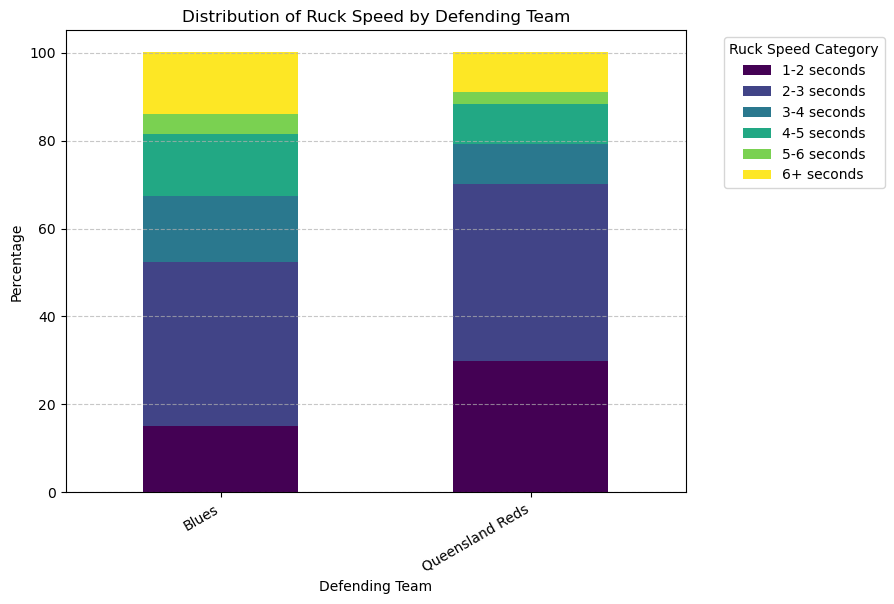

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

# Plot stacked bar chart
ax = ruck_speed_counts.plot(kind="bar", stacked=True, colormap="viridis", figsize=(8, 6))

# Formatting
plt.ylabel("Percentage")
plt.xlabel("Defending Team")
plt.title("Distribution of Ruck Speed by Defending Team")
plt.legend(title="Ruck Speed Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Rotate x-axis labels at an angle to prevent overlap
plt.xticks(rotation=30, ha="right")  # Rotate by 30 degrees and align right

# Show the plot
plt.show()


#### Attack

In [18]:
# Group by "Attacking team" and calculate summary statistics
summary_stats = df.groupby("Attacking team")["Ruck duration"].describe()
summary_stats

,count,mean,std,min,25%,50%,75%,max
Attacking team,,,,,,,,
Blues,79.0,3.015696,1.718144,1.12,1.94,2.48,3.44,9.40
Queensland Reds,92.0,3.523478,1.900965,1.08,2.15,2.72,4.56,9.56


In [19]:
# Count occurrences and convert to percentages
ruck_speed_counts = (
    df.groupby("Attacking team")["Ruck speed"]
    .value_counts(normalize=True)  # Normalize to get percentages
    .mul(100)  # Convert to percentage
    .round(1)  # Round to 1 significant digit
    .unstack(fill_value=0)  # Reshape for better readability
)

# Display the result
ruck_speed_counts


Ruck speed,1-2 seconds,2-3 seconds,3-4 seconds,4-5 seconds,5-6 seconds,6+ seconds
Attacking team,,,,,,
Blues,29.9,40.3,9.1,9.1,2.6,9.1
Queensland Reds,15.1,37.2,15.1,14.0,4.7,14.0


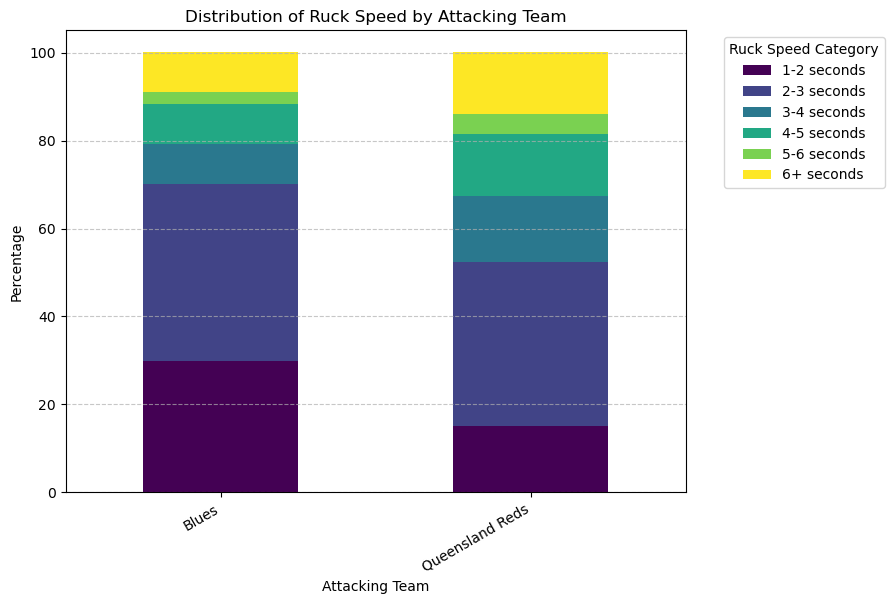

In [20]:
# Plot stacked bar chart
ax = ruck_speed_counts.plot(kind="bar", stacked=True, colormap="viridis", figsize=(8, 6))

# Formatting
plt.ylabel("Percentage")
plt.xlabel("Attacking Team")
plt.title("Distribution of Ruck Speed by Attacking Team")
plt.legend(title="Ruck Speed Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Rotate x-axis labels at an angle to prevent overlap
plt.xticks(rotation=30, ha="right")  # Rotate by 30 degrees and align right

# Show the plot
plt.show()


### Total duration

#### Defence

In [22]:
# Group by "Defending team" and calculate summary statistics
summary_stats = df.groupby("Defending team")["Total duration"].describe()
summary_stats

,count,mean,std,min,25%,50%,75%,max
Defending team,,,,,,,,
Blues,92.0,4.585652,1.914411,1.12,3.20,3.98,5.28,10.16
Queensland Reds,79.0,4.255190,2.135524,1.88,2.68,3.64,4.96,10.88


In [23]:
# Count occurrences and convert to percentages
total_speed_counts = (
    df.groupby("Defending team")["Total speed"]
    .value_counts(normalize=True)  # Normalize to get percentages
    .mul(100)  # Convert to percentage
    .round(1)  # Round to 1 significant digit
    .unstack(fill_value=0)  # Reshape for better readability
)

# Display the result
total_speed_counts


Total speed,1-2 seconds,2-3 seconds,3-4 seconds,4-5 seconds,5-6 seconds,6+ seconds
Defending team,,,,,,
Blues,1.2,18.6,29.1,18.6,9.3,23.3
Queensland Reds,5.2,29.9,29.9,11.7,5.2,18.2


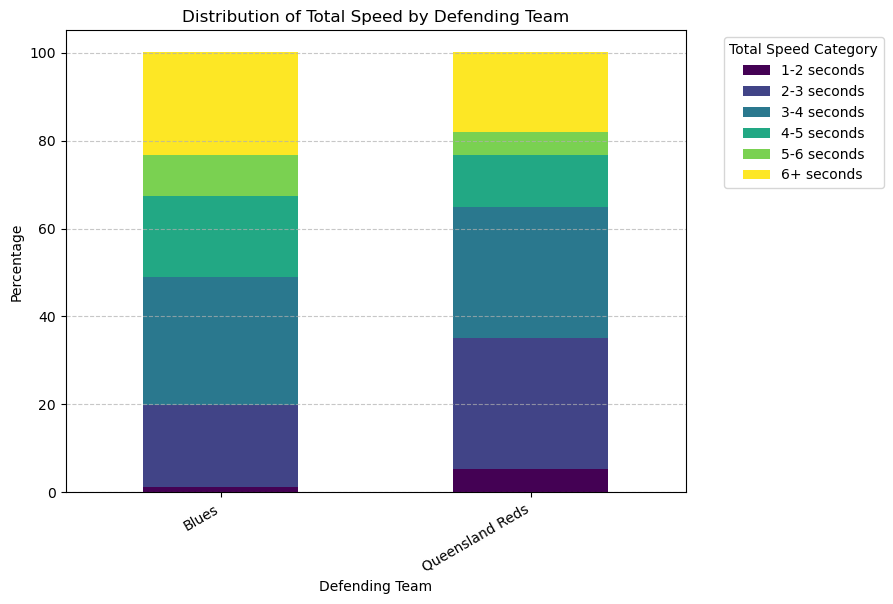

In [24]:
# Plot stacked bar chart
ax = total_speed_counts.plot(kind="bar", stacked=True, colormap="viridis", figsize=(8, 6))

# Formatting
plt.ylabel("Percentage")
plt.xlabel("Defending Team")
plt.title("Distribution of Total Speed by Defending Team")
plt.legend(title="Total Speed Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Rotate x-axis labels at an angle to prevent overlap
plt.xticks(rotation=30, ha="right")  # Rotate by 30 degrees and align right

# Show the plot
plt.show()


#### Attack

In [26]:
# Group by "Defending team" and calculate summary statistics
summary_stats = df.groupby("Attacking team")["Total duration"].describe()
summary_stats

,count,mean,std,min,25%,50%,75%,max
Attacking team,,,,,,,,
Blues,79.0,4.255190,2.135524,1.88,2.68,3.64,4.96,10.88
Queensland Reds,92.0,4.585652,1.914411,1.12,3.20,3.98,5.28,10.16


In [27]:
# Count occurrences and convert to percentages
total_speed_counts = (
    df.groupby("Attacking team")["Total speed"]
    .value_counts(normalize=True)  # Normalize to get percentages
    .mul(100)  # Convert to percentage
    .round(1)  # Round to 1 significant digit
    .unstack(fill_value=0)  # Reshape for better readability
)

# Display the result
total_speed_counts


Total speed,1-2 seconds,2-3 seconds,3-4 seconds,4-5 seconds,5-6 seconds,6+ seconds
Attacking team,,,,,,
Blues,5.2,29.9,29.9,11.7,5.2,18.2
Queensland Reds,1.2,18.6,29.1,18.6,9.3,23.3


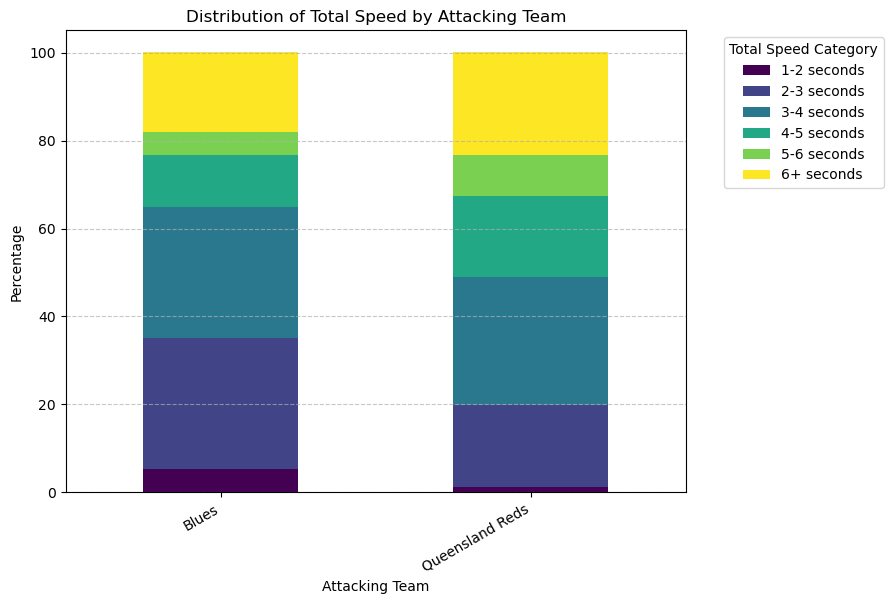

In [28]:
# Plot stacked bar chart
ax = total_speed_counts.plot(kind="bar", stacked=True, colormap="viridis", figsize=(8, 6))

# Formatting
plt.ylabel("Percentage")
plt.xlabel("Attacking Team")
plt.title("Distribution of Total Speed by Attacking Team")
plt.legend(title="Total Speed Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Rotate x-axis labels at an angle to prevent overlap
plt.xticks(rotation=30, ha="right")  # Rotate by 30 degrees and align right

# Show the plot
plt.show()


### FIT

#### Defence

In [30]:
# Group by "Defending team" and calculate summary statistics
summary_stats = df.groupby("Defending team")["FIT"].describe()
summary_stats

,count,mean,std,min,25%,50%,75%,max
Defending team,,,,,,,,
Blues,92.0,1.062174,0.64379,0.04,0.64,0.92,1.33,3.2
Queensland Reds,79.0,1.239494,0.93393,0.04,0.60,0.96,1.50,4.2


In [31]:
# Count occurrences and convert to percentages
FIT_counts = (
    df.groupby("Defending team")["FIT category"]
    .value_counts(normalize=True)  # Normalize to get percentages
    .mul(100)  # Convert to percentage
    .round(1)  # Round to 1 significant digit
    .unstack(fill_value=0)  # Reshape for better readability
)

# Display the result
FIT_counts


FIT category,0-1 seconds,1-2 seconds,2-3 seconds,3-4 seconds,4-5 seconds
Defending team,,,,,
Blues,52.3,40.7,3.5,3.5,0.0
Queensland Reds,54.5,28.6,7.8,7.8,1.3


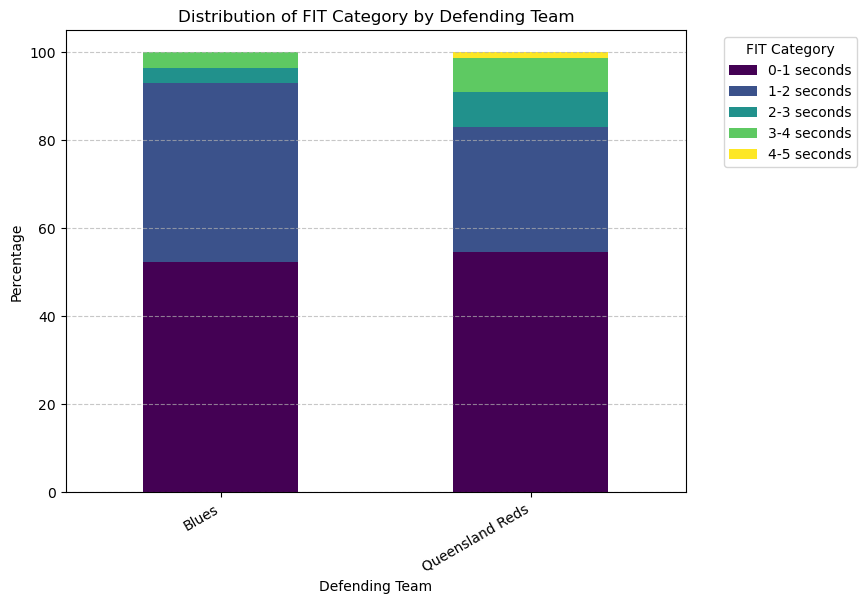

In [32]:
# Plot stacked bar chart
ax = FIT_counts.plot(kind="bar", stacked=True, colormap="viridis", figsize=(8, 6))

# Formatting
plt.ylabel("Percentage")
plt.xlabel("Defending Team")
plt.title("Distribution of FIT Category by Defending Team")
plt.legend(title="FIT Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Rotate x-axis labels at an angle to prevent overlap
plt.xticks(rotation=30, ha="right")  # Rotate by 30 degrees and align right

# Show the plot
plt.show()

#### Attack

In [34]:
# Group by "Defending team" and calculate summary statistics
summary_stats = df.groupby("Attacking team")["FIT"].describe()
summary_stats

,count,mean,std,min,25%,50%,75%,max
Attacking team,,,,,,,,
Blues,79.0,1.239494,0.93393,0.04,0.60,0.96,1.50,4.2
Queensland Reds,92.0,1.062174,0.64379,0.04,0.64,0.92,1.33,3.2


In [35]:
# Count occurrences and convert to percentages
FIT_counts = (
    df.groupby("Attacking team")["FIT category"]
    .value_counts(normalize=True)  # Normalize to get percentages
    .mul(100)  # Convert to percentage
    .round(1)  # Round to 1 significant digit
    .unstack(fill_value=0)  # Reshape for better readability
)

# Display the result
FIT_counts


FIT category,0-1 seconds,1-2 seconds,2-3 seconds,3-4 seconds,4-5 seconds
Attacking team,,,,,
Blues,54.5,28.6,7.8,7.8,1.3
Queensland Reds,52.3,40.7,3.5,3.5,0.0


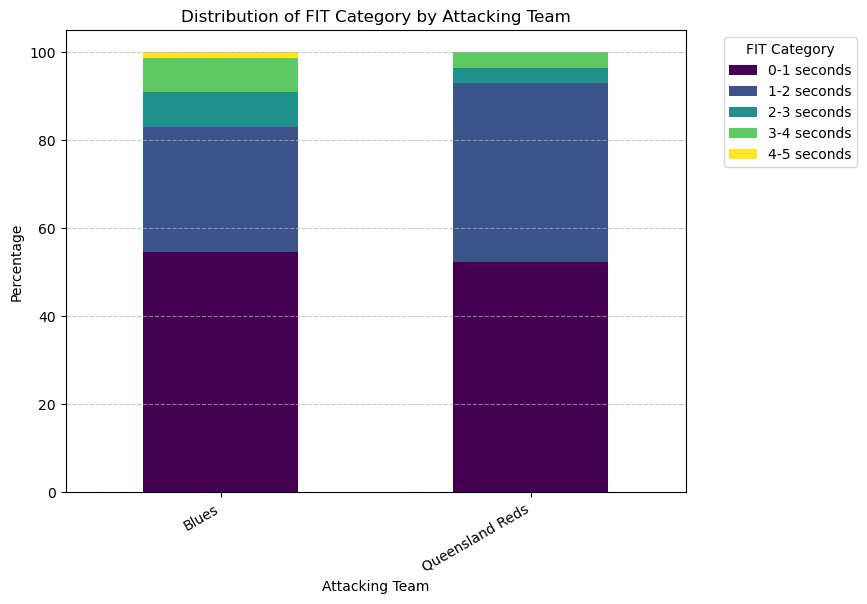

In [36]:
# Plot stacked bar chart
ax = FIT_counts.plot(kind="bar", stacked=True, colormap="viridis", figsize=(8, 6))

# Formatting
plt.ylabel("Percentage")
plt.xlabel("Attacking Team")
plt.title("Distribution of FIT Category by Attacking Team")
plt.legend(title="FIT Category", bbox_to_anchor=(1.05, 1), loc="upper left")
plt.grid(axis="y", linestyle="--", alpha=0.7)

# Rotate x-axis labels at an angle to prevent overlap
plt.xticks(rotation=30, ha="right")  # Rotate by 30 degrees and align right

# Show the plot
plt.show()

### Reds

In [38]:
df_reds = df[df["Defending team"]=="Queensland Reds"]
df_reds.sort_values(by=['FIT'], ascending=False, inplace=True)
df_reds

/var/folders/8t/hjvww9j95jg35mrz2jnr9rdw0000gp/T/ipykernel_73714/2365594199.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_reds.sort_values(by=['FIT'], ascending=False, inplace=True)


,Game ID,Competition,Season,Home team,Away team,Attacking team,Defending team,Time,x_start,y_start,...,1st Tackler,2nd Tackler,3rd Tackler,4th Tackler,5th Tackler,5th+ Tackler,FIT,Ruck speed,Total speed,FIT category
100,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_04045,47,49,...,Lukhan Salakaia-Loto,Zane Nonggorr,,,,,4.20,3-4 seconds,6+ seconds,4-5 seconds
144,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_06619,89,43,...,Ryan Smith,Angus Blyth,,,,,3.80,2-3 seconds,6+ seconds,3-4 seconds
111,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_04257,96,21,...,Zane Nonggorr,Sef Fa'agase,,,,,3.60,6+ seconds,6+ seconds,3-4 seconds
54,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,1_01820,98,38,...,Dre Pakeho,Sef Fa'agase,Hunter Paisami,,,,3.56,4-5 seconds,6+ seconds,3-4 seconds
49,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,1_01644,69,36,...,Fraser McReight,Lachie Anderson,,,,,3.28,2-3 seconds,5-6 seconds,3-4 seconds
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
115,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_04410,72,4,...,Dre Pakeho,,,,,,0.28,2-3 seconds,3-4 seconds,0-1 seconds
166,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_07757,68,52,...,Seru Uru,John Bryant,,,,,0.08,1-2 seconds,1-2 seconds,0-1 seconds
107,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_04235,85,26,...,Tate McDermott,Jock Campbell,,,,,0.08,1-2 seconds,1-2 seconds,0-1 seconds
117,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_04422,73,14,...,Zane Nonggorr,,,,,,0.04,2-3 seconds,2-3 seconds,0-1 seconds


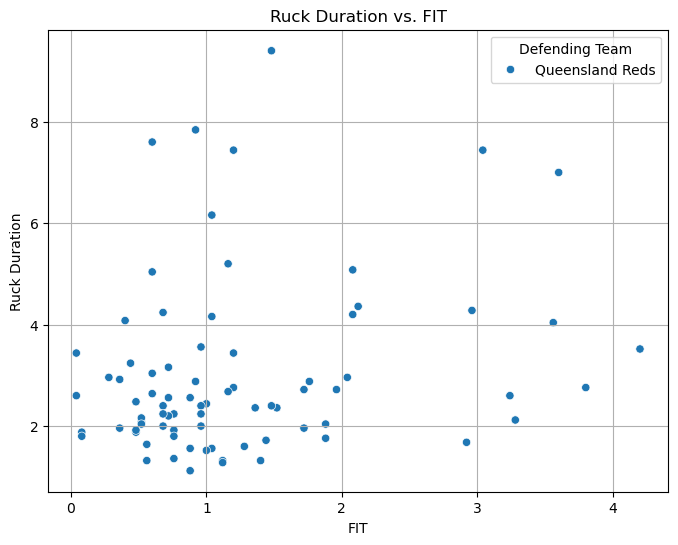

In [39]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot
plt.figure(figsize=(8, 6))
sns.scatterplot(x=df_reds["FIT"], y=df_reds["Ruck duration"], hue=df_reds["Defending team"])

# Labels and title
plt.xlabel("FIT")
plt.ylabel("Ruck Duration")
plt.title("Ruck Duration vs. FIT")
plt.legend(title="Defending Team")
plt.grid(True)

plt.show()

In [40]:
threshold = 1.5

df_above_th = df_reds[df_reds["FIT"]>=threshold]
df_above_th

,Game ID,Competition,Season,Home team,Away team,Attacking team,Defending team,Time,x_start,y_start,...,1st Tackler,2nd Tackler,3rd Tackler,4th Tackler,5th Tackler,5th+ Tackler,FIT,Ruck speed,Total speed,FIT category
100,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_04045,47,49,...,Lukhan Salakaia-Loto,Zane Nonggorr,,,,,4.20,3-4 seconds,6+ seconds,4-5 seconds
144,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_06619,89,43,...,Ryan Smith,Angus Blyth,,,,,3.80,2-3 seconds,6+ seconds,3-4 seconds
111,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_04257,96,21,...,Zane Nonggorr,Sef Fa'agase,,,,,3.60,6+ seconds,6+ seconds,3-4 seconds
54,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,1_01820,98,38,...,Dre Pakeho,Sef Fa'agase,Hunter Paisami,,,,3.56,4-5 seconds,6+ seconds,3-4 seconds
49,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,1_01644,69,36,...,Fraser McReight,Lachie Anderson,,,,,3.28,2-3 seconds,5-6 seconds,3-4 seconds
84,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,1_03538,98,49,...,Tim Ryan,Dre Pakeho,,,,,3.24,2-3 seconds,5-6 seconds,3-4 seconds
90,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,1_03758,22,44,...,Zane Nonggorr,Richie Asiata,,,,,3.04,6+ seconds,6+ seconds,3-4 seconds
101,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_04053,49,36,...,Seru Uru,Fraser McReight,,,,,2.96,4-5 seconds,6+ seconds,2-3 seconds
116,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,2_04418,72,9,...,Joe Brial,Seru Uru,,,,,2.92,1-2 seconds,4-5 seconds,2-3 seconds
39,945314,Super Rugby Pacific,2025,Queensland Reds,Blues,Blues,Queensland Reds,1_01013,98,58,...,,Tate McDermott,Tim Ryan,Richie Asiata,,,2.12,4-5 seconds,6+ seconds,2-3 seconds


# FOR DEBUG ONLY

In [42]:
# Get index of the row with max "Ruck duration" for each team
max_idx_per_team = df.groupby("Defending team")["Ruck duration"].idxmax()

# Extract those rows
max_ruck_rows = df.loc[max_idx_per_team]
max_ruck_rows.drop(['Competition', 'Season', 'x_start', 'y_start'], axis=1, inplace=True)

# Display the result
max_ruck_rows


,Game ID,Home team,Away team,Attacking team,Defending team,Time,Ruck duration,Ruck outcome,Total duration,1st Tackler,2nd Tackler,3rd Tackler,4th Tackler,5th Tackler,5th+ Tackler,FIT,Ruck speed,Total speed,FIT category
130,945314,Queensland Reds,Blues,Queensland Reds,Blues,2_05228,9.56,Won Outright,10.16,Anton Segner,Patrick Tuipulotu,,,,,0.60,6+ seconds,6+ seconds,0-1 seconds
98,945314,Queensland Reds,Blues,Blues,Queensland Reds,1_03952,9.40,Won Outright,10.88,Tim Ryan,,,,,,1.48,6+ seconds,6+ seconds,1-2 seconds


In [43]:
# Get index of the row with max "Ruck duration" for each team
max_idx_per_team = df.groupby("Defending team")["Total duration"].idxmax()

# Extract those rows
max_ruck_rows = df.loc[max_idx_per_team]
max_ruck_rows.drop(['Competition', 'Season', 'x_start', 'y_start'], axis=1, inplace=True)

# Display the result
max_ruck_rows


,Game ID,Home team,Away team,Attacking team,Defending team,Time,Ruck duration,Ruck outcome,Total duration,1st Tackler,2nd Tackler,3rd Tackler,4th Tackler,5th Tackler,5th+ Tackler,FIT,Ruck speed,Total speed,FIT category
130,945314,Queensland Reds,Blues,Queensland Reds,Blues,2_05228,9.56,Won Outright,10.16,Anton Segner,Patrick Tuipulotu,,,,,0.60,6+ seconds,6+ seconds,0-1 seconds
98,945314,Queensland Reds,Blues,Blues,Queensland Reds,1_03952,9.40,Won Outright,10.88,Tim Ryan,,,,,,1.48,6+ seconds,6+ seconds,1-2 seconds
